# Visualization of 1T0S0I Model using MCMCA (MA)

In [1]:
from plotly.offline import init_notebook_mode
from plotly.offline import iplot
from IPython.display import SVG
from plotly.io import to_image

# Initalize our notebook.
init_notebook_mode(connected=True)

# Toggle the line below if working locally.
is_local = False

if is_local:
    display_fig = lambda a: iplot(a)
else:
    display_fig = lambda a: SVG(to_image(a, format='svg'))

In [2]:
import plotly

# Specify file path(s) here.
db_file = ''
plotly.io.orca.config.executable = ''

In [3]:
from sqlite3 import connect
from pandas import read_sql_query

# Connect to all our of results databases.
conn = connect(db_file)

read_sql_query("""
    SELECT name, sql
    FROM sqlite_master
    WHERE type = 'table'
""", conn)

,name,sql
0,MA1T0S0I_OBSERVED,CREATE TABLE MA1T0S0I_OBSERVED (\n ...
1,MA1T0S0I_MODEL,CREATE TABLE MA1T0S0I_MODEL (\n RUN...
2,MA1T0S0I_RESULTS,CREATE TABLE MA1T0S0I_RESULTS (\n R...
3,MA1T0S0I_EXPR,CREATE TABLE MA1T0S0I_EXPR (\n RUN_...


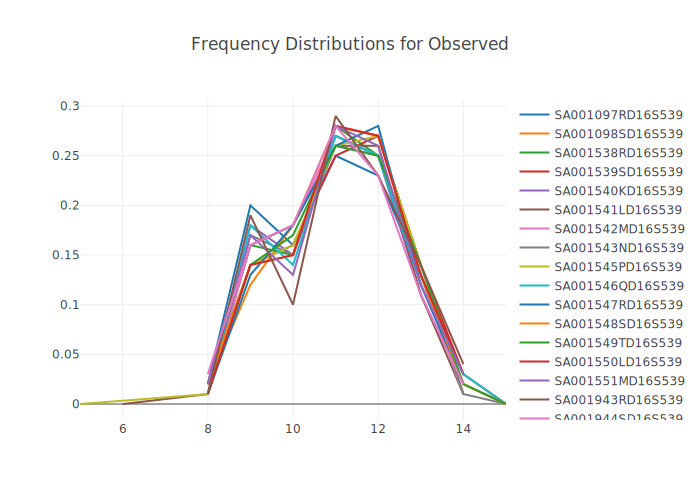

In [4]:
from plotly.graph_objs import Scatter, Layout, Figure

observation_ids = read_sql_query("""
    SELECT DISTINCT POP_ID
    FROM MA1T0S0I_OBSERVED
""", conn)['POP_ID']

observation_plots = [
    Scatter(x=read_sql_query(f"""
                SELECT ELL
                FROM MA1T0S0I_OBSERVED
                WHERE POP_ID LIKE "{a}"
                ORDER BY ELL
            """, conn)['ELL'], 
            y=read_sql_query(f"""
                SELECT ELL_FREQ
                FROM MA1T0S0I_OBSERVED
                WHERE POP_ID LIKE "{a}"
                ORDER BY ELL
            """, conn)['ELL_FREQ'], mode='lines', name=a)
    for a in observation_ids
]

fig = Figure(data=observation_plots,
             layout=Layout(title='Frequency Distributions for Observed'))
display_fig(fig)

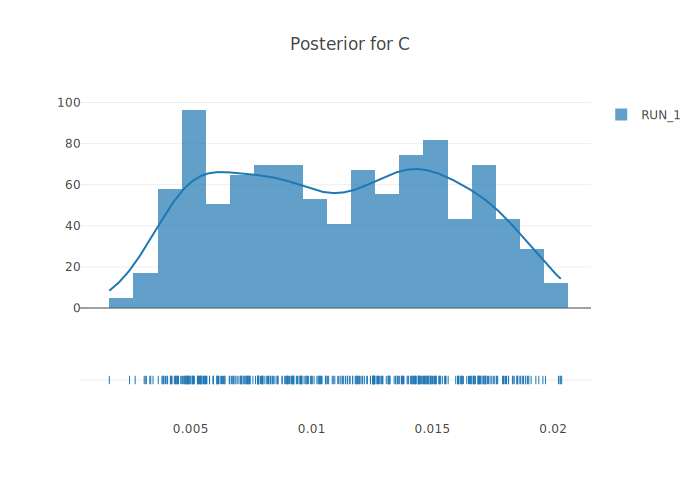

In [5]:
from plotly.figure_factory import create_distplot

param_c = read_sql_query("""
    SELECT C
    FROM MA1T0S0I_MODEL
""", conn)['C']
c_sigma = conn.execute("""
    SELECT CAST(FIELD_VAL AS DECIMAL)
    FROM MA1T0S0I_EXPR
    WHERE FIELD_NAME LIKE "c_sigma"
""").fetchone()[0]

# Plot the distribution of C.
fig = create_distplot([param_c], ["RUN_1"], bin_size=c_sigma)
fig['layout'].update(title='Posterior for C')
display_fig(fig)

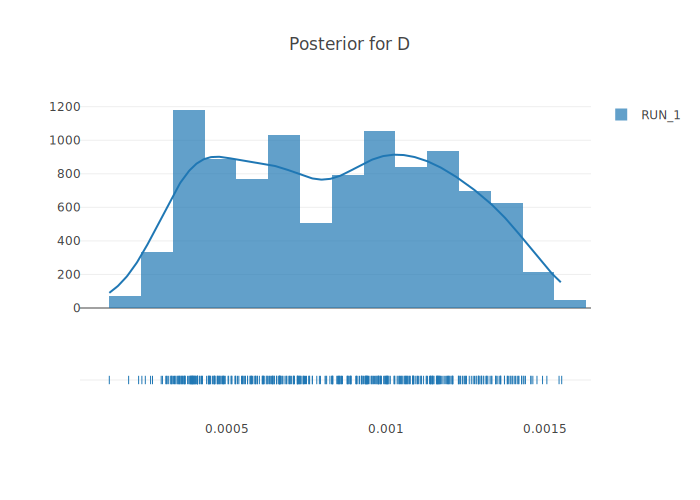

In [6]:
# Repeat for D.
param_d = read_sql_query("""
    SELECT D
    FROM MA1T0S0I_MODEL
""", conn)['D']
d_sigma = conn.execute("""
    SELECT CAST(FIELD_VAL AS DECIMAL)
    FROM MA1T0S0I_EXPR
    WHERE FIELD_NAME LIKE "d_sigma"
""").fetchone()[0]

fig = create_distplot([param_d], ["RUN_1"], bin_size=d_sigma)
fig['layout'].update(title='Posterior for D')
display_fig(fig)

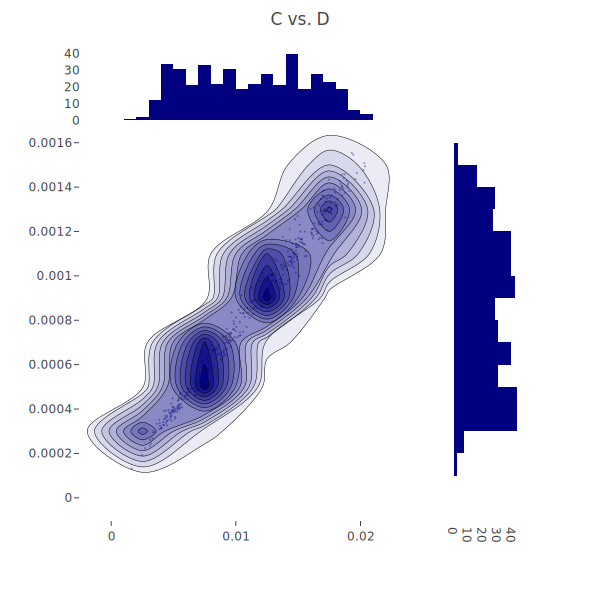

In [7]:
from plotly.figure_factory import create_2d_density

# Plot the density of C and D.
fig = create_2d_density(param_c, param_d)
fig['layout'].update(title='C vs. D')
display_fig(fig)

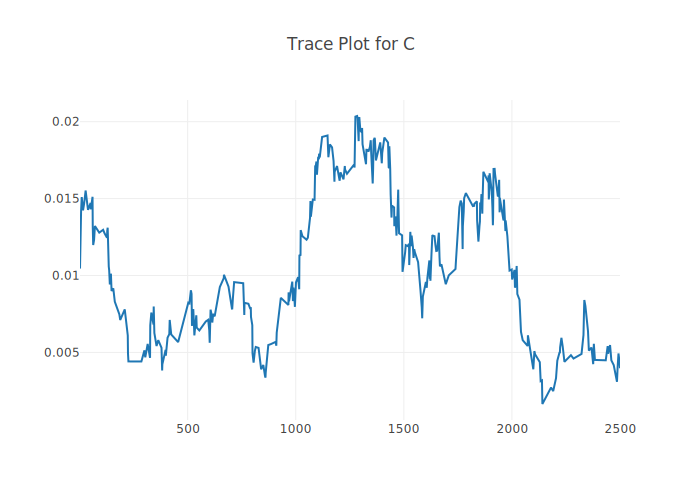

In [8]:
from plotly.graph_objs import Scatter, Layout, Figure

# Plot a trace plot for C.
param_proposed = read_sql_query("""
    SELECT MA1T0S0I_RESULTS.PROPOSED_TIME
    FROM MA1T0S0I_RESULTS
    INNER JOIN MA1T0S0I_MODEL USING (RUN_R, TIME_R)
""", conn)['PROPOSED_TIME']

trace_c = Scatter(
    x=param_proposed,
    y=param_c,
    mode='lines',
)

fig = Figure(data=[trace_c], 
             layout=Layout(title='Trace Plot for C', showlegend = False))
display_fig(fig)

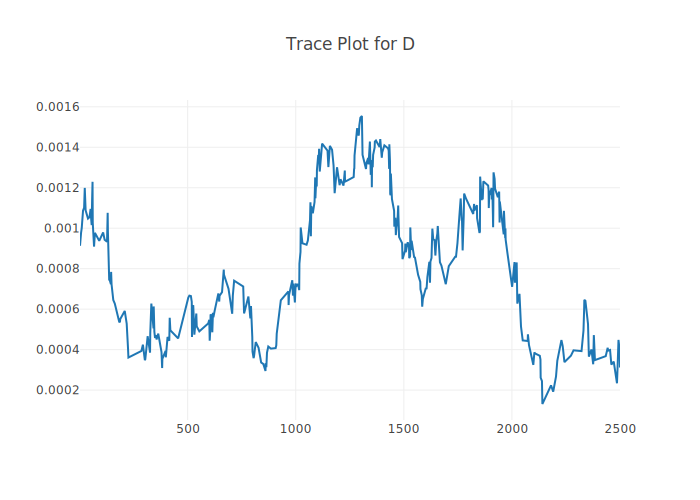

In [9]:
# Plot trace plot for D.
trace_d = Scatter(
    x=param_proposed,
    y=param_d,
    mode='lines',
)

fig = Figure(data=[trace_d], 
             layout=Layout(title='Trace Plot for D', showlegend = False))
display_fig(fig)

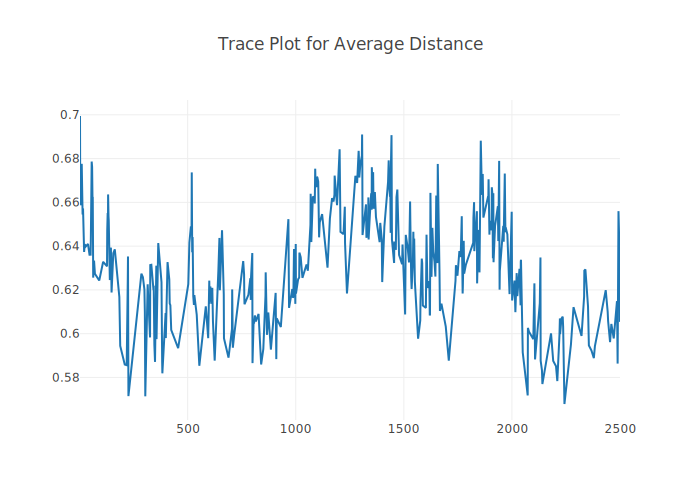

In [10]:
# Plot trace plot for average distance.
param_exp_delta = read_sql_query("""
    SELECT MA1T0S0I_RESULTS.EXPECTED_DELTA
    FROM MA1T0S0I_RESULTS
    INNER JOIN MA1T0S0I_MODEL USING (RUN_R, TIME_R)
""", conn)['EXPECTED_DELTA']

trace_exp_delta = Scatter(
    x=param_proposed,
    y=param_exp_delta,
    mode='lines',
)

fig = Figure(data=[trace_exp_delta], 
             layout=Layout(title='Trace Plot for Average Distance', showlegend = False))
display_fig(fig)

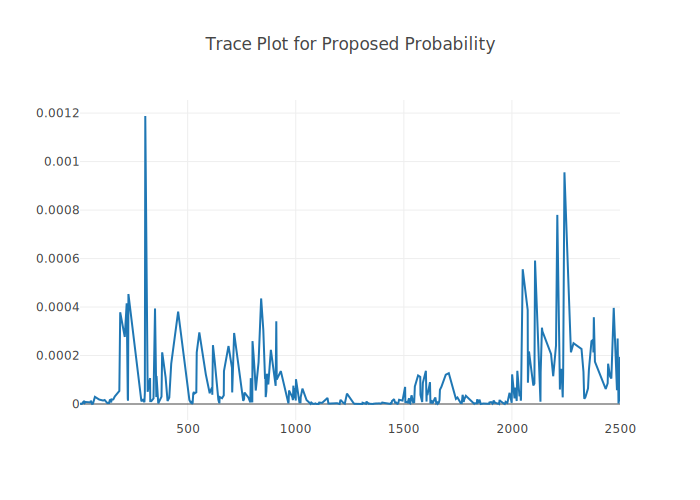

In [11]:
# Plot trace plot for proposal probability.
param_proposed_p = read_sql_query("""
    SELECT MA1T0S0I_RESULTS.P_PROPOSED
    FROM MA1T0S0I_RESULTS
    INNER JOIN MA1T0S0I_MODEL USING (RUN_R, TIME_R)
""", conn)['P_PROPOSED']

trace_proposed_p = Scatter(
    x=param_proposed,
    y=param_proposed_p,
    mode='lines',
)

fig = Figure(data=[trace_proposed_p], 
             layout=Layout(title='Trace Plot for Proposed Probability', showlegend = False))
display_fig(fig)

In [12]:
conn.close()  # Just some cleanup.